In [1]:
# IMPORTS
# =======

import numpy as np
import sounddevice as sd
import librosa as lbr
from random import random
from dpd_environment import DPDEnvironment
from dynamic_percussion_dataset import DynamicPercussionDataset
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import tikzplotlib as tikzplot
from pathlib import Path

D:\Programs\miniconda3\envs\tensorflow14\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
D:\Programs\miniconda3\envs\tensorflow14\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
Using TensorFlow backend.
D:\Programs\miniconda3\envs\tensorflow14\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synony

In [2]:
# UTILITIES
# =========

%matplotlib notebook

def get_frames_only(embframes):
    ret = []
    for frame in embframes:
        ret.append(frame['embedding'])
    return np.array(ret)


def get_audio_only(embframes, length):
    ret = []
    for frame in embframes:
        metadata = frame['metadata']
        path = metadata['raw_audio_path']
        audio, sr = lbr.load(path, sr=None)
        ret.append(np.abs(audio[0:length]))
    return np.array(ret)


def onpick(event):

    sample_id = event.artist.get_label()

    openl3_package = openl3_package_wrapper.get_package_by_id(sample_id)

    audio, sr = openl3_package.get_audio()
    sd.play(audio, samplerate=sr)

    print(f"Click {openl3_package.metadata['raw_audio_path']}")

In [3]:
# SETTINGS
# ========

# Environment
env = DPDEnvironment(settings_file='dataset_envs/env.json')
audio_dir = env.get_audio_dir()
ser_dir = env.get_serialization_dir()

# Data
data_type = 'oneshot'  # Affects the method for calculating the mean embedding.
use_embeddings_for_visualization = True

# Pre-computed embedding folders
openl3_linear_music_512_True_05 = "openl3_linear_music_512_True_0.5"
openl3_linear_music_512_True_01 = "openl3_linear_music_512_True_0.1"
openl3_linear_music_6144_True_01 = "openl3_linear_music_6144_True_0.1"
openl3_linear_music_6144_True_05 = "openl3_linear_music_6144_True_0.5"
openl3_mel128_music_512_True_05 = "openl3_mel128_music_512_True_0.5"
openl3_mel256_env_512_True_05 = "openl3_mel256_env_512_True_0.5"
openl3_mel256_music_512_True_01 = "openl3_mel256_music_512_True_0.1"
openl3_mel256_music_512_True_05 = "openl3_mel256_music_512_True_0.5"
openl3_mel256_music_6144_True_01 = "openl3_mel256_music_6144_True_0.1"

# TeX Exporting
save_tikz = False

# Colors
colors = ['#ff0000', '#0000ff', '#00cc00', '#aa7401', '#ff9900',
          '#9f01ee', '#85c154', '#f1616b', '#aae61b', '#a5e0d3',
          '#c100a1', '#b40d33', '#210b50', '#00e311', '#eeafa5',
          '#947a1c', '#332fa1', '#d93c1b', '#a82eeb', '#3e8beb',
          '#7de767', '#e2048b', '#42b506', '#cf87ca', '#fff000',
          '#791066', '#e83196']
colors_by_superclass = {
    "BD": "#336bdc",
    "SN": "#fa9b2b",
    "TOM": "#5aba3c",
    "HH": "#000000",
    "CYM": "#f32d46",
    "PERC": "#f319ca"
}
simple_coloring = False  # Color samples only by their superclass.

# Figure
figure_size = (10, 10)
include_model_details_in_figure = False
perplexities = [50]
num_subplots = (1, 1)


Processing BD_DAMP...
Processing BD_REG...
Processing CYM_CHINA...
Processing CYM_CRASH_REG...
Processing CYM_FX_SPLASH...
Processing CYM_FX_STACK...
Processing CYM_RIDE_BELL...
Processing CYM_RIDE_REG...
Processing HH_BELL...
Processing HH_CLOSED...
Processing HH_OPEN...
Processing HH_SEMI...
Processing PERC_CABASA...
Processing PERC_COWBELL...
Processing PERC_SHAKER...
Processing PERC_TAMB...
Processing PERC_VIBRASLAP...
Processing PERC_WOODBLOCK...
Processing SN_OFF_REG...
Processing SN_ON_BUZZ...
Processing SN_ON_CROSS...
Processing SN_ON_DAMP...
Processing SN_ON_REG...
Processing TOM_HI...
Processing TOM_LO...
Processing TOM_MED...


<IPython.core.display.Javascript object>


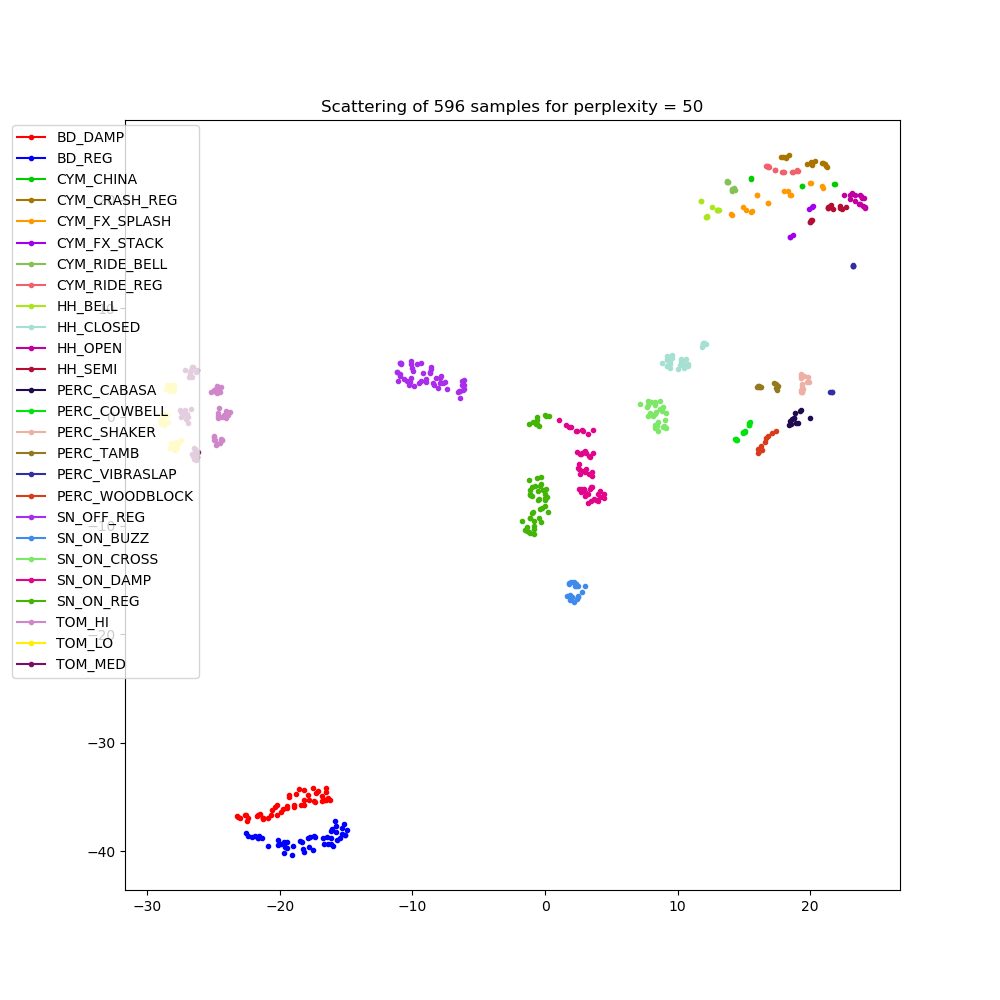

input_repr = mel256
content_type = music
embedding_size = 512
hop_size = 0.1
weights: oneshot


In [4]:
# PLOTTING
# ========

# The pre-calculated embeddings model.
selected_model = openl3_mel256_music_512_True_01

# Initialize the dataset.
dataset = DynamicPercussionDataset(audio_directory=audio_dir,
                                   serialization_directory
                                   =ser_dir + "/" + selected_model)

# Load the embeddings.
dataset.load_serialized_data(class_filter=None)

# Get the embedding packages.
openl3_package_wrapper = dataset.get_embedding_wrapper()

# Get the sample classes included in the loaded embeddings.
sample_classes = openl3_package_wrapper.get_class_labels()

# This will contain a single embedding for each sample.
embedding_frames = []

class_colors = {}

for sample_class in sample_classes:
    print(f'Processing {sample_class}...')
    samples = openl3_package_wrapper[sample_class]
    for sample in samples:
        embeddings = sample.embeddings
        metadata = sample.metadata

        # How many embeddings are used to calculate the mean embedding.
        preferred_num_mean = 10
        num_mean = preferred_num_mean if preferred_num_mean < len(embeddings) \
                                      else len(embeddings)

        # For oneshot data it's good to give more weight to the first
        # embeddings when calculating the mean embedding. The first second
        # contains most of the aural information in the sample.
        if data_type == 'oneshot':
            weight = 1 / 2**(np.arange(0, num_mean))
        else:
            weight = np.ones(num_mean)

        embedding = None
        for i in range(num_mean):
            if embedding is None:
                embedding = embeddings[0]
            else:
                embedding = np.add(embedding,
                                   weight[i] * embeddings[i])

        embedding *= (1 / np.sum(weight))  # Calculate the weighed mean.

        embedding_frames.append({'embedding': embedding,
                                 'metadata': metadata})

    class_colors[sample_class] = colors.pop(0)


frames = get_frames_only(embedding_frames)

fig = plt.figure(figsize=(figure_size[0], figure_size[1]))

counter = 1
plt_text_set = False

# If there are more than 1 perplexities defined, the loop will
# run accordingly.
for perplexity in perplexities:

    ax = fig.add_subplot(num_subplots[0], num_subplots[1], counter)
    
    # Calculate t-SNE projections of the embeddings.
    tsne_points \
        = TSNE(n_components=2,
               perplexity=perplexity,
               n_iter=5000,
               n_iter_without_progress=500).fit_transform(frames)
    
    classes_sample_points = {}
    superclasses_added = []
    
    lines = []
    titles = []
    
    # Plotting of each sample.
    for i in range(len(frames)):
        metadata = embedding_frames[i]['metadata']
        sample_id = metadata['sample_id']
        sample_class = metadata['class']
        sample_superclass = sample_class.split("_")[0]
        openl3_settings = metadata["openl3settings"]

        sample_point = tsne_points[i]
        class_color \
            = colors_by_superclass[sample_superclass] if simple_coloring else class_colors[sample_class]

        marker = '.'

        line, = ax.plot(sample_point[0],
                        sample_point[1],
                        color=class_color,
                        marker=marker,
                        picker=2,
                        label=sample_id)
        
        # Each point has the sample id as label, so the audio can
        # be played back when the point is clicked.

        if sample_class not in list(classes_sample_points.keys()):
            classes_sample_points[sample_class] = [sample_point]
            if simple_coloring:
                if sample_superclass not in superclasses_added:
                    lines.append(line)
                    titles.append(sample_superclass)
                    superclasses_added.append(sample_superclass)
            else:
                lines.append(line)
                titles.append(sample_class)
            if not plt_text_set:
                figtext = f"input_repr = {openl3_settings['input_repr']}\n" \
                          f"content_type = {openl3_settings['content_type']}\n" \
                          f"embedding_size = {openl3_settings['embedding_size']}\n" \
                          f"hop_size = {openl3_settings['hop_size']}\n" \
                          f"weights: {data_type}"
                print(figtext)
                plt_text_set = True
                if include_model_details_in_figure:
                    plt.figtext(.8, .75, figtext)

        else:
            classes_sample_points[sample_class].append(sample_point)
    
    # The legend will be drawn only on the first run of the loop.
    if counter == 1:
        ax.legend(lines, titles, loc="upper left",
                  bbox_to_anchor=(-0.155, 0.9, 1., 0.102))

    ax.set_title(f'Scattering of {len(frames)} samples for perplexity'
                 f' = {perplexity}')

    counter += 1

# Add event listener for the point clicks.
fig.canvas.mpl_connect('pick_event', onpick)

# The figure can also be saved as .tex file.
if not save_tikz:
    plt.show()
else:
    tex_savedir = env.get_tex_dir()
    tex_filename = f"scatterplot" \
                   f"{openl3_settings['input_repr']}" \
                   f"{openl3_settings['content_type']}" \
                   f"{openl3_settings['embedding_size']}" \
                   f"{openl3_settings['hop_size']}" \
                   f"p{perplexity}" \
                   f"num{counter}.tex"

    tex_fullpath = Path(tex_savedir + tex_filename).resolve()
    counter = 0
    while tex_fullpath.is_file():
        counter += 1
        tex_filename = f"scatterplot" \
                       f"{openl3_settings['input_repr']}" \
                       f"{openl3_settings['content_type']}" \
                       f"{openl3_settings['embedding_size']}" \
                       f"{openl3_settings['hop_size']}" \
                       f"p{perplexity}" \
                       f"num{counter}.tex"
        tex_fullpath = Path(tex_savedir + tex_filename).resolve()

    tikzplot.save(str(tex_fullpath))